# **Анализ тональности и выявление трендов в отзывах о продукте**

## Цель работы 
Проанализировать отзывы пользователей о новой линейке "умных" устройств для дома: определить общее восприятие продукта, выявить проблемные зоны и возможные направления для улучшения следующего поколения устройств.


## Задачи
1. Разработать систему сбора и предобработки текстовых отзывов из различных источников
2. Провести анализ тональности (sentiment analysis) отзывов для оценки общего восприятия продукта
3. Применить методы тематического моделирования для выявления ключевых аспектов продукта
4. Провести анализ трендов во времени для отслеживания изменения восприятия продукта
5. Выявить наиболее критичные проблемы и возможности для улучшения на основе анализа отзывов


## Датасет
В качестве источника использован открытый датасет **Amazon Product Reviews**, содержащий ~3.8 миллиона пользовательских отзывов, оставленных на различных товарах. Для анализа выбрана репрезентативная подвыборка из 760 000 строк. Каждый отзыв содержит:
- числовой рейтинг (от 1 до 5),
- текстовое описание,
- временную метку (timestamp), которая позволяет отслеживать изменения восприятия во времени.

Пример записи:  
 `4  ` | `Fan is good; Amazon Warehouse not so much: Pretty standard fan...` | `1621973695328`


## Загрузка зависимостей

In [1]:
import os
import bz2
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [2]:
PATH_TRAIN = r"C:\Users\era_k\_jupyter notebook\case3\train.ft.txt.bz2"
PATH_TEST  = r"C:\Users\era_k\_jupyter notebook\case3\test.ft.txt.bz2"

## Загрузка данных

In [3]:
file_size = os.path.getsize(PATH_TEST)

lines = []

with bz2.open(PATH_TEST, "rt", encoding="utf-8") as f, \
     tqdm(total=file_size, unit="B", unit_scale=True, desc="Чтение строк") as pbar:
    for raw in f:
        byte_len = len(raw.encode("utf-8"))
        pbar.update(byte_len)

        line = raw.strip()
        if not line:
            continue
            
        # split по первому пробелу и последнему пробелу для timestamp
        try:
            label_part, rest = line.split(" ", 1)
            text_part, ts_part = rest.rsplit(" ", 1)
            # print(label_part, ts_part)
        except ValueError:
            continue
            
        lines.append({
            "rating": int(label_part.replace("__label__", "")),
            "text": text_part,
            "timestamp": ts_part
        })

Чтение строк: 211MB [00:15, 14.0MB/s]                                                                                  


## Вид данных (датафрейм)

In [4]:
df = pd.DataFrame(lines)
print("Loaded:", len(df), "rows")
df.head()

Loaded: 760000 rows


,rating,text,timestamp
0,4,Good for about a month!: It was great for 3 we...,1578640836326
1,4,Fan is good; Amazon Warehouse not so much: Pre...,1621973695328
2,5,Paper towel holder: The bulk metal holder is s...,1639599887456
3,5,"Great!: Reasonable price, smooth cuts, and sta...",1362843318000
4,5,PERFECT: THIS ACTUALLY MAKES DRINKING WATER FU...,1566586842353


## Data preprocessing
Стандартные этапы подготовки данных к анализу:
* Удаление полных дубликатов
* Приведение данных к корректным форматам

In [5]:
df['text'] = df['text'].str.lower()

In [6]:
df_unique = df.drop_duplicates(subset='text').copy()
print(f"Было строк: {len(df)}, стало: {len(df_unique)}")

Было строк: 760000, стало: 726365


Загружено 760 000 строк. После удаления дубликатов — 726 365 уникальных отзывов.  
Это значит, что ~4.4% данных повторяются, что типично для агрегаторов (копии с сайтов, кросс-платформенные публикации).  
Удаление дубликатов важно для получения объективной статистики: иначе популярные мнения будут искусственно завышены. 

In [7]:
# Преобразование timestamp в дату
df_unique['date'] = pd.to_datetime(df_unique['timestamp'].astype('int64'), unit='ms')
df_unique.head()

,rating,text,timestamp,date
0,4,good for about a month!: it was great for 3 we...,1578640836326,2020-01-10 07:20:36.326
1,4,fan is good; amazon warehouse not so much: pre...,1621973695328,2021-05-25 20:14:55.328
2,5,paper towel holder: the bulk metal holder is s...,1639599887456,2021-12-15 20:24:47.456
3,5,"great!: reasonable price, smooth cuts, and sta...",1362843318000,2013-03-09 15:35:18.000
4,5,perfect: this actually makes drinking water fu...,1566586842353,2019-08-23 19:00:42.353


In [8]:
df_unique["sentiment"] = df_unique["rating"].map(lambda n: "neg" if n<=2 else ("pos" if n>=4 else "neu"))
df_unique["sentiment"].value_counts()

sentiment
pos    576600
neg     97382
neu     52383
Name: count, dtype: int64

**Пример негативных отзывов:**

In [9]:
with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    display(df_unique[df_unique['sentiment'] == "neg"].head(3))

,rating,text,timestamp,date,sentiment
6,2,i did not like.: i did not like,1492939729000,2017-04-23 09:28:49.000,neg
16,1,"do not buy: i threw these darts away after i realized i missed the return deadline. the flags come off all the time, the tips bend easily and the darts rarely stuck in the dart board. i do not recommend these.",1658281724698,2022-07-20 01:48:44.698,neg
24,2,"very small, doesnt pop all the kernels.: one serving and you have to be careful about timing...easy to burn. have never been able to pop all the kernels. i would look for a better one.",1663670597569,2022-09-20 10:43:17.569,neg


**Пример нейтральных отзывов:**

In [10]:
with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    display(df_unique[df_unique['sentiment'] == 'neu'].head(3))

,rating,text,timestamp,date,sentiment
13,3,flimsy but usable.: kind of flimsy and screwing on the cap feels a bit cheap. but it is usable and fits our needs.,1494611666000,2017-05-12 17:54:26,neu
21,3,"one-sided support not ideal for people who move their heads a lot: i cant say this was the revolutionary product everyone else said it would be. it is comfortable to use for sleeping on planes, but not ideal if, like me, youre someone who shifts sides constantly. i found myself having to rotate the support every time i wanted to lay my head on a different direction. if it had support on both sides i would like it much, much more.",1454175621000,2016-01-30 17:40:21,neu
22,3,three stars: needs better instructions for what i need to make the stupid thing work,1463098655000,2016-05-13 00:17:35,neu


**Пример положительных отзывов:**

In [11]:
with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    display(df_unique[df_unique['sentiment'] == 'pos'].head(3))

,rating,text,timestamp,date,sentiment
0,4,good for about a month!: it was great for 3 weeks but i assume the speaker blew because now the sound quality it terrible,1578640836326,2020-01-10 07:20:36.326,pos
1,4,"fan is good; amazon warehouse not so much: pretty standard fan, strong power, good for kitchen use. 6.5 sones turns out to be pretty loud, though. i would estimate it about as loud as standing 10 feet from a handheld hair dryer on low, and i definitely have to raise my voice to be heard over it. this fan does not include a damper.br br the major problem i had was ordering an item rated as used, good from amazon warehouse. it was described as having a small cosmetic imperfection on the interior of the item. nonsense. the housing was so bent that the fan could not spin inside it, and one of the two mount holders on the side were also bent so badly you could not slide the mount bars through. if forced to guess i think someone dropped it on a hard surface at least twice. basically the thing was unusable as is. luckily it turned out i did not actually need the housing and was able to take the fanmotor out and use it. amazon gave me a partial refund on the price, so there was some compensation there. if warehouse has something not as described, do not hesitate to return it.",1621973695328,2021-05-25 20:14:55.328,pos
2,5,"paper towel holder: the bulk metal holder is sturdy, attractive and does the job. gr8 value. highly tecommend",1639599887456,2021-12-15 20:24:47.456,pos


## Фильтрация по длине отзывов

Для повышения качества анализа была выполнена фильтрация по длине текста. Были исключены:

- **слишком короткие отзывы (менее 30 символов)** — такие тексты часто являются односложными шаблонными похвалами или жалобами, не содержащими конкретной информации, полезной для анализа;
- **слишком длинные отзывы (более 1870 символов)** — такие тексты, как правило, охватывают несколько несвязанных тем, включают личные истории или сторонние рассуждения, что искажает результаты тематического моделирования (особенно методов вроде LDA, которые предполагают одну тематику на документ).

В результате было отобрано 681 870 отзывов, что обеспечивает репрезентативность при одновременном повышении "чистоты" корпуса.

In [12]:
df['text_length'] = df['text'].str.len()
df_unique['text_length'] = df_unique['text'].str.len()

In [13]:
print('1% квантиль')

# Находим 1% квантиль (границу самых коротких текстов)
q = df_unique['text_length'].quantile(0.01)

# Оставляем только те отзывы, у которых длина больше этого значения
tmp = df_unique[df_unique['text_length'] > q]

# Посмотреть сколько осталось
print(tmp.shape, q)

print(df_unique[df_unique['text_length'] < int(q)]['text'].value_counts())

1% квантиль
(718649, 6) 19.0
text
five stars: nice      1
five stars: good      1
util: buenísimo       1
two stars: love it    1
good: very good       1
                     ..
suitable: nice        1
niv: very colorful    1
price: perfect fit    1
wet cute: wet cute    1
.: loved it           1
Name: count, Length: 6255, dtype: int64


In [14]:
print('5% квантиль')

# Находим 5% квантиль (границу самых коротких текстов)
q_min = df_unique['text_length'].quantile(0.05)

# Оставляем только те отзывы, у которых длина больше этого значения
tmp = df_unique[df_unique['text_length'] > q_min]

# Посмотреть сколько осталось
print(tmp.shape, q_min)

print(df_unique[df_unique['text_length'] < q_min]['text'].value_counts())

5% квантиль
(689139, 6) 30.0
text
five stars: worked great         1
four stars: great deal.          1
great game: love it !!           1
five stars: nice                 1
good game: good game             1
                                ..
perfect size!: perfect size!     1
good buy: good buy!              1
great gadget!: it works well.    1
.: loved it                      1
love it: perfect gift            1
Name: count, Length: 33871, dtype: int64


> При сравнении 1% и 5% квантилей мы выбрали 5%, так как этот вариант обеспечивает более широкую и репрезентативную выборку отзывов. Это позволяет получить более объективные результаты при анализе тональности, выявлении тематических аспектов и отслеживании трендов. Благодаря большему охвату данных удаётся точнее определить ключевые проблемы и возможности для улучшения продукта.\

In [15]:
print('99% квантиль')

# Находим 5% квантиль (границу самых коротких текстов)
q_max = df_unique['text_length'].quantile(0.99)

# Оставляем только те отзывы, у которых длина больше этого значения
tmp = df_unique[df_unique['text_length'] < q_max]

# Посмотреть сколько осталось
print(tmp.shape, q_max)

99% квантиль
(719096, 6) 1870.0


In [16]:
with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    print(df_unique[df_unique['text_length'] > q_max]['text'].head(2))

46    well made and simple to install as long as your existing hosevalve sizes comply: in the box, youll find a manual, the faucet itself (with hot and cold hoses, and two others that connect together to make the sprayer hose), a weight (attaches to sprayer hose), a baseplate, two 38 m to 12 f adapters (to connect from faucet hotcold hoses to your valves), and finally a threaded piece to tighten the faucet to your sink from below.br br instructions are very straightforward and clear, even for someone like me who has never installed any faucets or messed with plumbing-related items before. the first thing youll wanna do is shut off the water - find your hot and cold water valves under the sink and turn those off. to make sure theyre tight enough, try running hot and cold water from your existing faucet - if youre still getting water, then youll want to twist the appropriate valve even tighter to the off position. once the water is off, disconnect your existing faucets hoses from the val

> Мы отбрасываем отзывы, попадающие в 99% квантиль по длине текста, так как такие отзывы часто оказываются слишком длинными и содержат множество тем, деталей или несвязанных аспектов. Это может негативно повлиять на качество автоматического анализа тональности и тематического моделирования, так как в одном большом отзыве может встречаться смешанная тональность или сразу несколько тем.  
>
> Исключая экстремально длинные отзывы, мы делаем выборку более однородной и фокусируемся на наиболее информативных и релевантных откликах, что позволяет получать более точные результаты анализа и выявлять основные тренды и ключевые аспекты продукта.


In [17]:
filtered_q_df = df_unique[(df_unique['text_length'] > q_min) & (df_unique['text_length'] < q_max)]

In [18]:
filtered_q_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 681870 entries, 0 to 759998
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   rating       681870 non-null  int64         
 1   text         681870 non-null  object        
 2   timestamp    681870 non-null  object        
 3   date         681870 non-null  datetime64[ns]
 4   sentiment    681870 non-null  object        
 5   text_length  681870 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 36.4+ MB


In [19]:
# import fasttext
import pandas as pd
from tqdm import tqdm
from langdetect import detect
from functools import lru_cache

In [20]:
@lru_cache(maxsize=100_000)  # кэш на 100k уникальных строк
def cached_detect(text):
    return detect(text)

def detect_lang(text):
    if not isinstance(text, str) or not text.strip():
        return "unk"
    try:
        return cached_detect(text)
    except:
        return "unk"

In [21]:
tqdm.pandas()

filtered_q_df['lang'] = filtered_q_df['text'].progress_apply(detect_lang)

100%|█████████████████████████████████████████████████████████████████████████| 681870/681870 [32:21<00:00, 351.13it/s]
C:\Users\era_k\AppData\Local\Temp\ipykernel_16112\1815037274.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_q_df['lang'] = filtered_q_df['text'].progress_apply(detect_lang)


## Предобработка текстовых данных

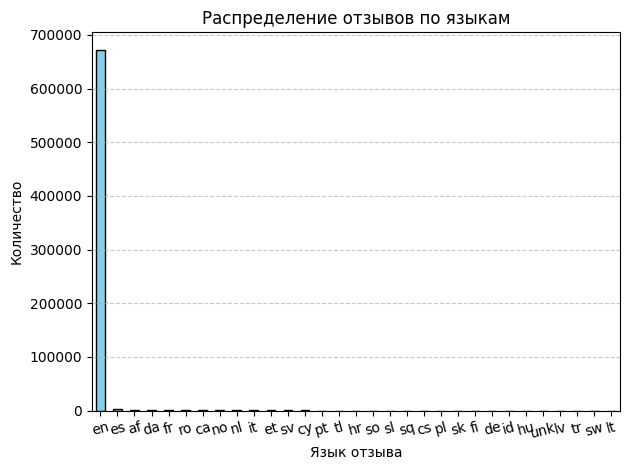

In [22]:
vc = filtered_q_df['lang'].value_counts()

ax = vc.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Язык отзыва')
plt.ylabel('Количество')
plt.title('Распределение отзывов по языкам')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
df_filtered = filtered_q_df[filtered_q_df['lang'] == 'en']
print(f"Было строк: {len(filtered_q_df)}, стало: {len(df_filtered)}")

Было строк: 681870, стало: 671275


После автоматического определения языка оказалось, что **более 98% всех отзывов написаны на английском языке**. Остальные языки составляют очень незначительную долю (менее 2%), а потому:
- не формируют статистически значимые кластеры,
- затрудняют унифицированную обработку (нужны отдельные модели лемматизации, стоп-слов и т.д.),
- в большинстве случаев относятся к локализованным продуктам или рынкам, не входящим в анализируемую продуктовую линейку.

Таким образом, для обеспечения однородности и фокусировки на массовом восприятии глобального рынка, все неанглоязычные отзывы были удалены. Итоговая выборка — 671 275 записей.

In [24]:
dirty = df_filtered[df_filtered['text'].str.contains(r"http\S+|www\S+", regex=True)]

print(f"Строк с ссылками: {len(dirty):,}")

with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    print(dirty['text'].head(2))

dirty = df_filtered[df_filtered['text'].str.contains(r"\S+@\S+", regex=True)]

print(f"Строк с mail: {len(dirty):,}")

with pd.option_context('display.max_colwidth', None):  # Временно убираем ограничение
    print(dirty['text'].head(2))


Строк с ссылками: 489
2076                                                                                                                                                                                                                                                                                                                                                                                                                    five stars: excellent card! you will love the extra room and the speed! for more information go here: https:www.sdcard.orgdevelopersoverviewspeed_class
2798    just wow!: this drill saved my rear!!! i needed to drill several holes into a concrete foundation to install moldingthresholds for a laminate wood floor i just installed. i have a battery-operated drill that has a hammer-drill setting on it, and it was just not happening. so, i bought this bosch after some quick research, and wow! this along with the recommended bits (bosch hck005 5 piece carbide-tipped sds

___________
В ходе анализа содержимого текстов отзывов были выявлены внешние ссылки (например, начинающиеся с `http`, `www`) и email-адреса. Количество таких строк оказалось крайне незначительным:
- Ссылки присутствовали примерно в **0.07%** отзывов (489 из ~671 тыс. записей);
- Email-адресов **не обнаружено вовсе**.

#### Что это значит:

1. **Наличие ссылок в отзыве — потенциальный индикатор спама** или навязчивой рекламы, особенно если ссылка ведёт на внешний ресурс.
2. Несмотря на низкую долю, такие отзывы могут негативно повлиять на тематическое моделирование, поскольку содержат "мусорные" токены и искажают статистику по словам.

**Важно:** Даже минимальное количество "шумных" данных может создавать ложные сигналы в анализе. Их удаление — стандартная, но важная мера при работе с отзывами.

In [25]:
import re

def clean_text(text: str) -> str:
    # 1) Убираем ссылки
    text = re.sub(r"http\S+|www\S+", "", text)
    # 2) Убираем email
    text = re.sub(r"\S+@\S+", "", text)
    # 3) Двойные br → перенос строки
    text = re.sub(r'\bbr[\s]*br\b', '\n', text, flags=re.IGNORECASE)
    # 4) Одиночные br → пробел
    text = re.sub(r'\bbr\b', ' ', text, flags=re.IGNORECASE)
    # 5) Сводим повторяющиеся пробелы и табы в один пробел
    text = re.sub(r'[ \t]+', ' ', text)
    # 6) Сводим подряд более одного переноса строки в один
    text = re.sub(r'\n{2,}', '\n', text)
    # 7) Убираем пробелы по краям
    return text


In [26]:
df_filtered.loc[:, 'text'] = df_filtered['text'].apply(clean_text)

In [27]:
import spacy
from tqdm import tqdm

nlp = spacy.load(
    "en_core_web_sm",
    disable=["parser", "ner", "textcat"]
)

def preprocess(doc):
    return " ".join(
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop
    )

texts = df_filtered["text"].dropna().astype(str).tolist()

lemmas = []
for doc in tqdm(nlp.pipe(texts, batch_size=2000, n_process=4), total=len(texts), desc="Lemmatizing"):
    lemmas.append(preprocess(doc))

df_filtered["clean_text"] = lemmas


Lemmatizing: 100%|████████████████████████████████████████████████████████████| 671275/671275 [19:29<00:00, 574.20it/s]
C:\Users\era_k\AppData\Local\Temp\ipykernel_16112\806533676.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["clean_text"] = lemmas


In [28]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671275 entries, 0 to 759998
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   rating       671275 non-null  int64         
 1   text         671275 non-null  object        
 2   timestamp    671275 non-null  object        
 3   date         671275 non-null  datetime64[ns]
 4   sentiment    671275 non-null  object        
 5   text_length  671275 non-null  int64         
 6   lang         671275 non-null  object        
 7   clean_text   671275 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 46.1+ MB


In [29]:
df_filtered.head()

,rating,text,timestamp,date,sentiment,text_length,lang,clean_text
0,4,good for about a month!: it was great for 3 we...,1578640836326,2020-01-10 07:20:36.326,pos,121,en,good month great week assume speaker blow soun...
1,4,fan is good; amazon warehouse not so much: pre...,1621973695328,2021-05-25 20:14:55.328,pos,1084,en,fan good amazon warehouse pretty standard fan ...
2,5,paper towel holder: the bulk metal holder is s...,1639599887456,2021-12-15 20:24:47.456,pos,109,en,paper towel holder bulk metal holder sturdy at...
3,5,"great!: reasonable price, smooth cuts, and sta...",1362843318000,2013-03-09 15:35:18.000,pos,133,en,great reasonable price smooth cut stay sharp t...
4,5,perfect: this actually makes drinking water fu...,1566586842353,2019-08-23 19:00:42.353,pos,214,en,perfect actually make drinking water fun promo...


## Анализ тональности

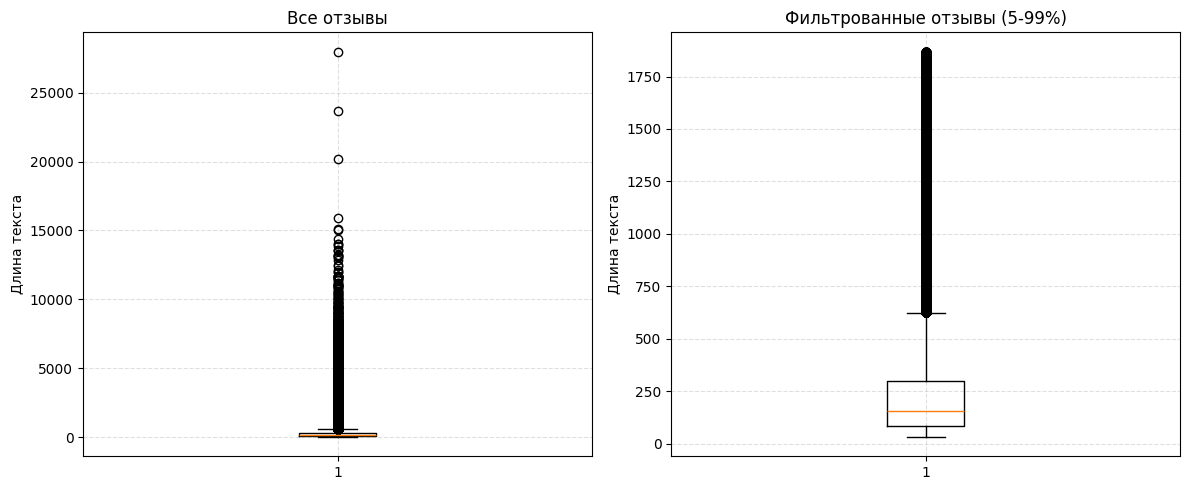

In [30]:
# Создаём 2 subplot'а в одном ряду
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Первый boxplot — для всех отзывов
axes[0].boxplot(df['text_length'])
axes[0].set_title('Все отзывы')
axes[0].set_ylabel('Длина текста')
axes[0].grid(True, linestyle='--', alpha=0.4)  # Полупрозрачный грид

# Второй boxplot — для фильтрованных
axes[1].boxplot(filtered_q_df['text_length'])
axes[1].set_title('Фильтрованные отзывы (5-99%)')
axes[1].set_ylabel('Длина текста')
axes[1].grid(True, linestyle='--', alpha=0.4)  # Полупрозрачный грид

plt.tight_layout()
plt.show()


> Видим, что после применения фильтрации (удаление крайних 1% и 5% по длине) box-plot распределение стало значительно **более читаемым и информативным**.
> - В исходном графике длины варьировались от нескольких символов до **25 000+**, из-за чего основная масса данных была **визуально сжата** и скрыта среди выбросов.
> - После фильтрации большинство отзывов оказалось **в пределах 100–400 символов**, и распределение стало **более компактным и интерпретируемым**.

In [31]:
print(df_filtered['text_length'].describe(), end='\n\n')
print(filtered_q_df['text_length'].describe())

count    671275.000000
mean        247.997643
std         262.098018
min          31.000000
25%          84.000000
50%         160.000000
75%         303.000000
max        1869.000000
Name: text_length, dtype: float64

count    681870.000000
mean        245.144420
std         261.167007
min          31.000000
25%          82.000000
50%         157.000000
75%         299.000000
max        1869.000000
Name: text_length, dtype: float64


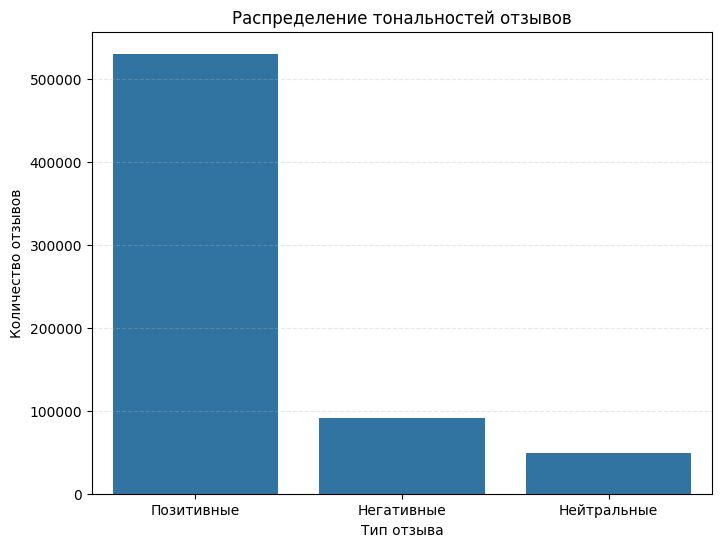

In [47]:
mapping = {
    'pos': 'Позитивные',
    'neu': 'Нейтральные',
    'neg': 'Негативные'
}

df_filtered.loc[:, 'sentiment_ru'] = df_filtered['sentiment'].map(mapping)
sentiment_counts = df_filtered['sentiment_ru'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values
)

plt.title('Распределение тональностей отзывов')
plt.xlabel('Тип отзыва')
plt.ylabel('Количество отзывов')
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

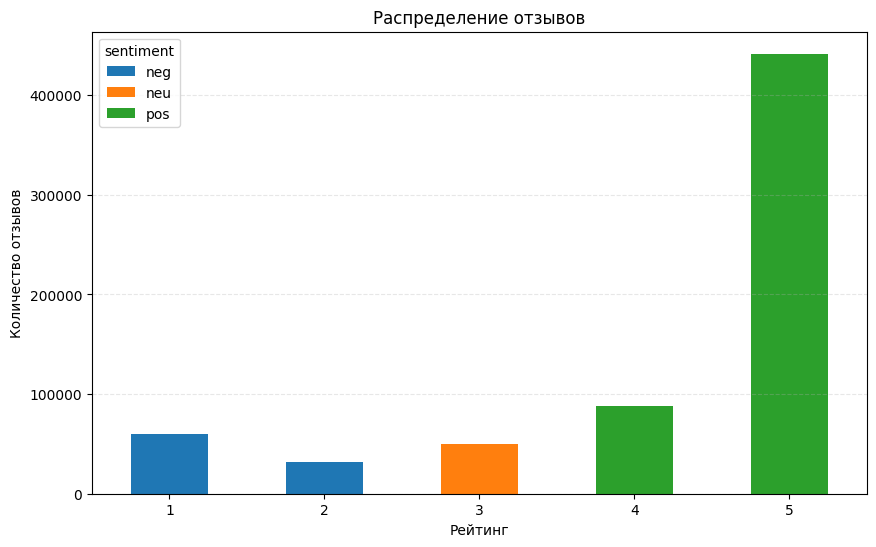

In [35]:
sentiment_rating = df_filtered.groupby(['rating', 'sentiment']).size().unstack().fillna(0)
sentiment_rating.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Распределение отзывов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество отзывов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.show()

Позитивные: 78.97%, Нейтральные: 7.36%, Негативные: 13.67%


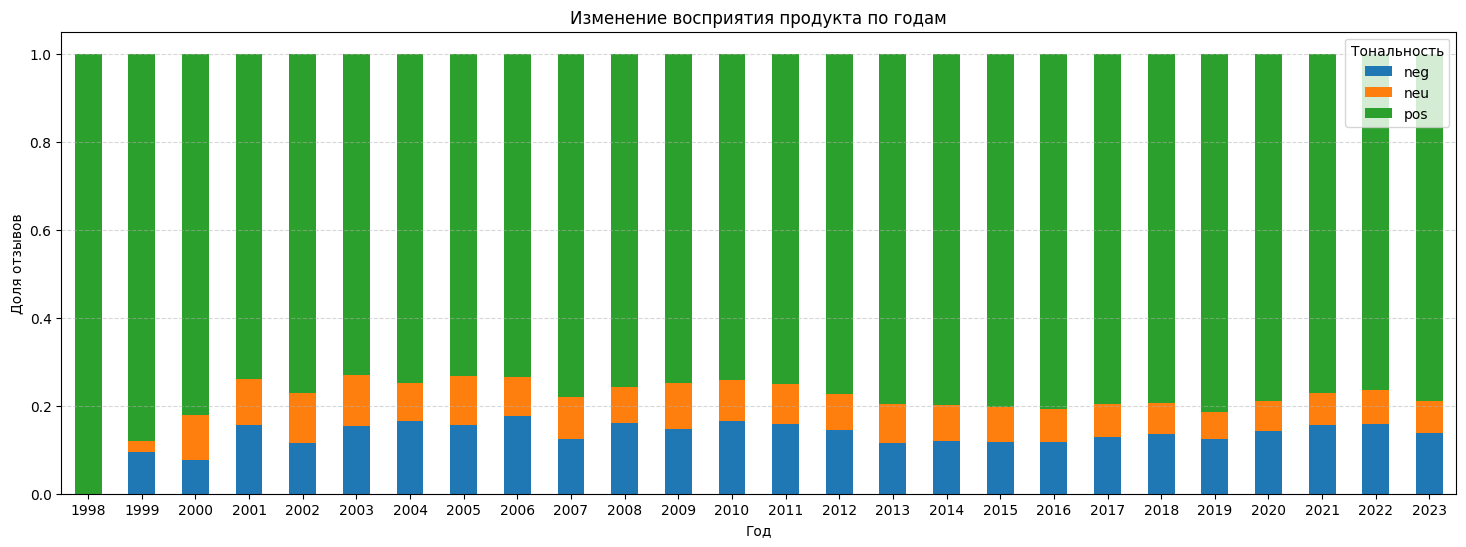

In [48]:
# Общая доля
total = len(df_filtered)
pos = (df_filtered['sentiment'] == 'pos').sum()
neu = (df_filtered['sentiment'] == 'neu').sum()
neg = (df_filtered['sentiment'] == 'neg').sum()

print(f'Позитивные: {pos/total:.2%}, Нейтральные: {neu/total:.2%}, Негативные: {neg/total:.2%}')

# По годам
df_filtered.loc[:, 'year'] = df_filtered['date'].dt.year
year_sentiment = df_filtered.groupby(['year', 'sentiment']).size().unstack().fillna(0)

year_sentiment_norm = year_sentiment.div(year_sentiment.sum(axis=1), axis=0)

year_sentiment_norm.plot(kind='bar', stacked=True, figsize=(18, 6))
plt.title('Изменение восприятия продукта по годам')
plt.xlabel('Год')
plt.ylabel('Доля отзывов')
plt.legend(title='Тональность')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем столбец с годом, если его еще нет (используем .loc чтобы избежать предупреждения)
df_filtered.loc[:, 'year'] = df_filtered['date'].dt.year

# Рассчитываем среднюю оценку по годам
mean_rating_by_year = df_filtered.groupby('year')['rating'].mean()

# Строим график
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_rating_by_year, marker='o', linewidth=2.5)

# Настраиваем внешний вид графика
plt.title('Средняя оценка продукта по годам', fontsize=14)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Средняя оценка', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 5)  # Если оценки по 5-балльной шкале

# Добавляем значения над точками
for year, rating in mean_rating_by_year.items():
    plt.text(year, rating + 0.1, f'{rating:.2f}', ha='center', va='bottom')

plt.show()

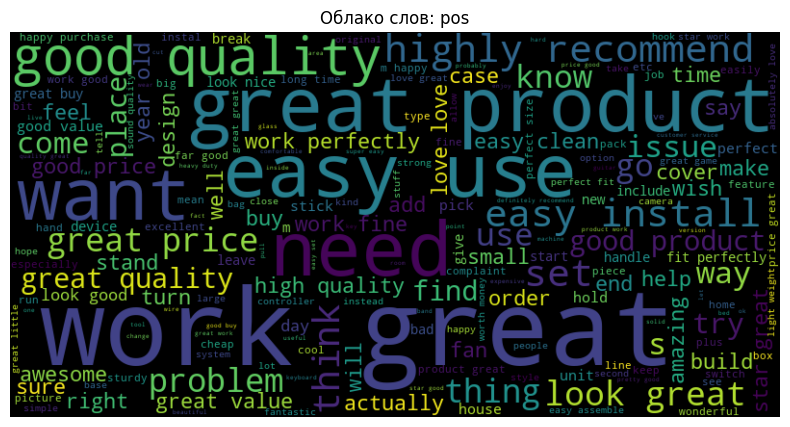

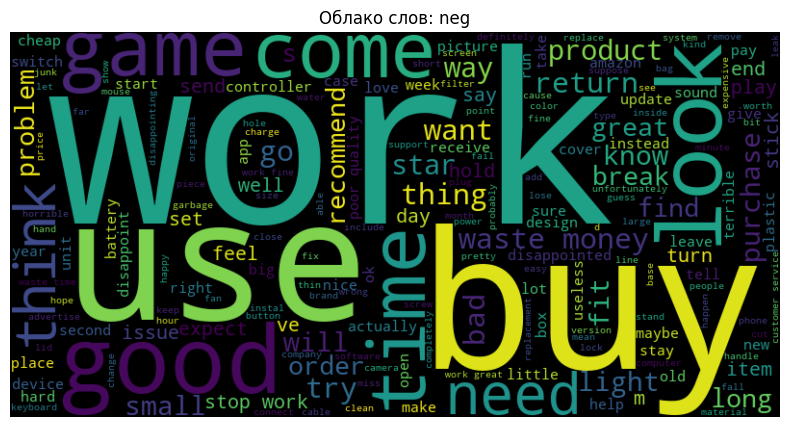

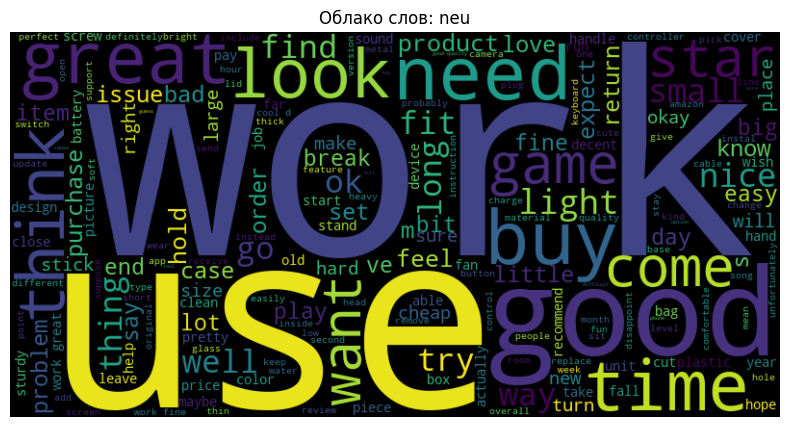

In [37]:
for sentiment in ['pos', 'neg', 'neu']:
    text = ' '.join(df_filtered[df_filtered['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Облако слов: {sentiment}')
    plt.show()

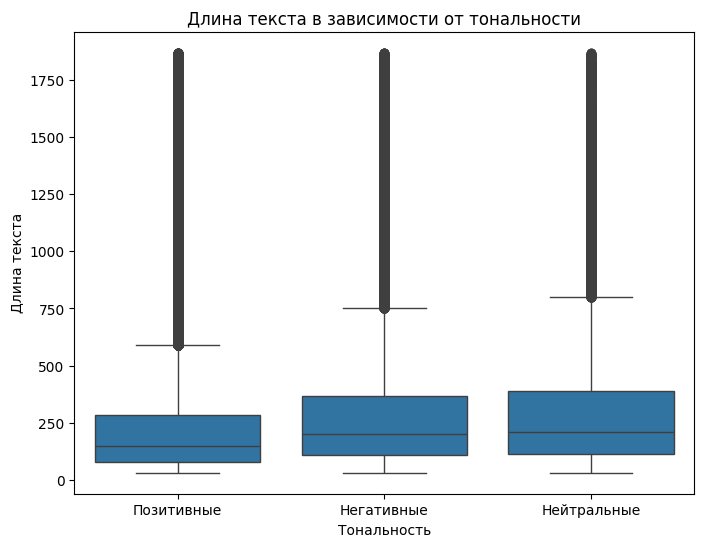

In [38]:
mapping = {
    'pos': 'Позитивные',
    'neg': 'Негативные',
    'neu': 'Нейтральные'
}

order = ['pos', 'neg', 'neu']
labels = [mapping[s] for s in order]

plt.figure(figsize=(8, 6))
ax = sns.boxplot(
    x='sentiment',
    y='text_length',
    data=df_filtered,
    order=order
)

ax.set_xticks(range(len(order)))
ax.set_xticklabels(labels)

plt.title('Длина текста в зависимости от тональности')
plt.xlabel('Тональность')
plt.ylabel('Длина текста')
plt.show()

#### **Выводы:**
Тональность отзыва определялась на основании выставленного рейтинга:
- **1–2 звезды** — негативные отзывы
- **3 звезды** — нейтральные
- **4–5 звезд** — позитивные

Распределение оказалось следующим:
- **Позитивные** — 78.97%
- **Нейтральные** — 7.36%
- **Негативные** — 13.67%

На первый взгляд, это выглядит как сильный показатель — почти 4 из 5 пользователей довольны. Однако с точки зрения **бизнес-анализа и управления продуктом**, особую ценность представляют как раз **негативные отзывы**, поскольку:

1. Они часто содержат **конкретные, детальные жалобы** — на материалы, функциональность, надежность, упаковку, батарею и т.д.
2. Именно они являются **источником инсайтов о том, что нужно исправить в первую очередь**, особенно при ограниченном бюджете.
3. Даже 13–14% недовольных пользователей — это очень ощутимый показатель, который напрямую влияет на рейтинг, количество возвратов и репутацию бренда на маркетплейсах.

Интересная закономерность: **негативные отзывы в среднем значительно длиннее позитивных**. Это может объясняться тем, что недовольные клиенты более склонны подробно описывать проблемы и свое недовольство. Таким образом, каждый такой отзыв содержит гораздо больше информации для принятия решений, чем краткая положительная реплика.

##### Распределение тональности отзывов по годам (без учёта 2024)
В 1998 году в выборке представлены исключительно позитивные отзывы, что, скорее всего, связано с ограниченным объёмом данных. Уже с 1999 года начинают появляться как негативные, так и нейтральные отзывы. 

Начиная с начала 2000-х, доля негативных отзывов постепенно растёт и затем стабилизируется на уровне около **15%**, с незначительными колебаниями. Нейтральные отзывы также становятся заметнее и достигают устойчивой доли в **6–8%**.

_Вывод:_ Начиная примерно с 2005 года, структура распределения отзывов по тональности становится устойчивой и сохраняется с небольшими колебаниями вплоть до 2023 года.

### Применить методы тематического моделирования для выявления ключевых аспектов продукта

In [39]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Подготовка корпуса
texts = df_filtered['clean_text'].tolist()

# 2. Векторизация (мешок слов)
vectorizer = CountVectorizer(
    max_df=0.95,      # игнорировать очень частые токены
    min_df=10,        # игнорировать слишком редкие
    stop_words='english',
    ngram_range=(1, 2) # можно попробовать биграммы
)
X = vectorizer.fit_transform(texts)

# 3. Обучение LDA
n_topics = 10  # число тем — подберите по смыслу
lda = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=10,
    learning_method='batch',
    random_state=42
)
lda.fit(X)

# 4. Вывод «топ‑слов» для каждой темы
n_top_words = 12
feature_names = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Тема {topic_idx + 1}: {', '.join(top_features)}")

# 5. (Опционально) Присвоение доминирующей темы каждому отзыву
topic_distrib = lda.transform(X)  # shape (n_docs, n_topics)
# df_filtered = df_filtered.copy()
df_filtered['dominant_topic'] = topic_distrib.argmax(axis=1) + 1


Тема 1: water, buy, break, product, return, work, purchase, time, filter, day, coffee, plastic
Тема 2: case, fit, controller, like, feel, mouse, nice, good, screen, button, come, work
Тема 3: sound, good, quality, like, price, need, use, guitar, screw, worth, come, bit
Тема 4: light, work, battery, bright, charge, great, use, turn, need, power, bulb, plug
Тема 5: look, small, like, perfect, fit, size, old, nice, color, work, need, buy
Тема 6: like, good, great, comfortable, music, song, cd, time, album, fit, wear, love
Тема 7: easy, use, great, work, clean, install, good, easy use, product, easy install, need, like
Тема 8: love, bag, buy, perfect, soft, cute, color, great, super, look, bed, beautiful
Тема 9: game, play, good, fun, great, like, time, work, cable, fan, buy, new
Тема 10: great, good, quality, price, product, work, star, nice, love, look, work great, buy


C:\Users\era_k\AppData\Local\Temp\ipykernel_16112\3264887270.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dominant_topic'] = topic_distrib.argmax(axis=1) + 1


In [40]:
df_filtered.groupby('dominant_topic')['rating'].value_counts(normalize=True).unstack().fillna(0)
df_filtered.groupby('dominant_topic')['sentiment'].value_counts(normalize=True).unstack().fillna(0)

sentiment,neg,neu,pos
dominant_topic,,,
1,0.414230,0.100950,0.484819
2,0.169147,0.121508,0.709345
3,0.179124,0.122228,0.698648
4,0.179094,0.081396,0.739509
5,0.097276,0.083981,0.818743
6,0.118604,0.084708,0.796687
7,0.064084,0.052290,0.883626
8,0.054361,0.045539,0.900100
9,0.173614,0.085980,0.740405


Для выявления повторяющихся аспектов, о которых чаще всего упоминают пользователи, была применена модель тематического моделирования LDA. На очищенном тексте (лемматизированном, без стоп-слов, на английском) было выделено **10 устойчивых тем**.

Каждая тема представляет собой совокупность слов, часто встречающихся в одном контексте. Ниже приведены самые яркие из них с краткими выводами:

### Тема 1: `water`, `buy`, `break`, `return`, `filter`
- Основные жалобы на **фильтры**, **поломки после покупки**, **необходимость возврата**.
- Часто встречается у устройств для воды, фильтрации или кофеварок.
- Доля негативной тональности — **41.4%**, наивысшая среди всех тем.
- _Вывод_: Один из главных источников пользовательского недовольства — низкая надежность или брак в фильтрующих/водяных устройствах.

### Тема 4: `light`, `battery`, `bright`, `charge`, `plug`
- Связана с **освещением**, **зарядкой**, **батареями**.
- Часто упоминаются проблемы со сроком службы аккумулятора, яркостью, питанием.
- _Вывод_: Ключевая техническая проблема во многих устройствах — плохая автономность или качество питания. Это критично для беспроводных решений.

### Тема 3: `sound`, `quality`, `guitar`, `screw`, `worth`
- Отзывы о **звуке**, **качестве сборки**, иногда — о музыкальных аксессуарах.
- Много упоминаний о том, что товар "не стоит своих денег" (`worth`, `price`).
- _Вывод_: Устройства, связанные со звуком (наушники, динамики), нередко вызывают претензии — пользователи воспринимают их как недостаточно качественные.

### Тема 7: `easy`, `use`, `install`, `clean`
- Преимущественно позитивные отзывы о **простоте установки и использования**.
- Доля позитивных отзывов — **88%**.
- _Вывод_: Простота — ключевой фактор лояльности. Устройства, которые легко использовать и установить, вызывают наибольшее удовлетворение.

### Тема 10: `great`, `quality`, `price`, `look`, `work great`
- Универсальные положительные фразы: "отличный товар", "хорошее качество", "нормальная цена".
- **95% отзывов — позитивные**, минимальное количество жалоб.
- _Вывод_: Эта тема отражает "успешные" товары, которые соответствуют ожиданиям — в основном из-за сочетания цены и качества.


### Провести анализ трендов во времени для отслеживания изменения восприятия продукта


C:\Users\era_k\AppData\Local\Temp\ipykernel_16112\3243366493.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')


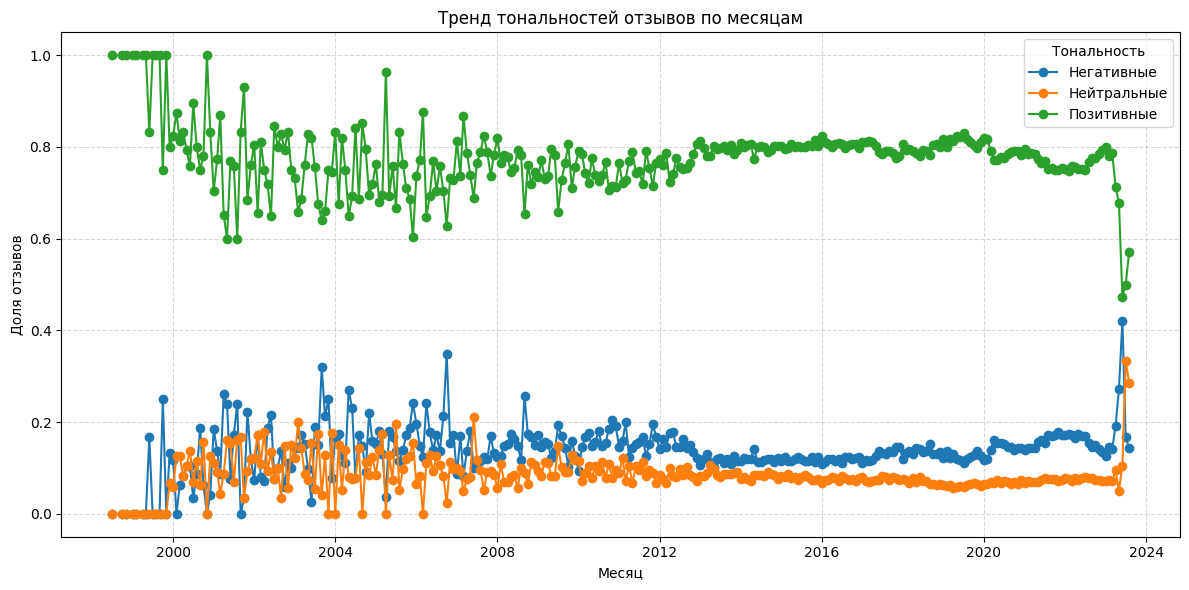

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Предположим, что df_filtered['date'] уже в datetime
# 1. Создаём столбец с периодом «год-месяц»
df_filtered['year_month'] = df_filtered['date'].dt.to_period('M')

# 2. Считаем количество отзывов каждой тональности в каждом месяце
monthly_counts = (
    df_filtered
    .groupby(['year_month', 'sentiment'])
    .size()
    .rename('count')
    .reset_index()
)

# 3. Переводим в «широкий» формат и нормируем по месяцу (получаем доли)
monthly_pivot = (
    monthly_counts
    .pivot(index='year_month', columns='sentiment', values='count')
    .fillna(0)
)
monthly_props = monthly_pivot.div(monthly_pivot.sum(axis=1), axis=0)

# 4. Если нужны русские подписи
mapping = {'pos': 'Позитивные', 'neg': 'Негативные', 'neu': 'Нейтральные'}
monthly_props = monthly_props.rename(columns=mapping)

# 5. Строим линейный график
plt.figure(figsize=(12, 6))
for col in monthly_props.columns:
    plt.plot(
        monthly_props.index.to_timestamp(),
        monthly_props[col],
        marker='o',
        label=col
    )

plt.title('Тренд тональностей отзывов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Доля отзывов')
plt.legend(title='Тональность')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(axis='x', alpha=0.5, linestyle='--')
plt.grid(axis='y', alpha=0.5, linestyle='--')
plt.show()


На приведенном графике визуализированы изменения долей **позитивных**, **нейтральных** и **негативных** отзывов в разбивке по **месяцам** за более чем 20-летний период.

### Ключевые наблюдения:

#### 1. **Стабильность и доминирование позитивных отзывов**
- На протяжении большей части наблюдаемого периода (примерно с 2004 по 2023 год) доля позитивных отзывов стабильно колебалась в районе **70-80%**. Это свидетельствует о высоком уровне удовлетворённости пользователей и, вероятно, сильных позициях продукта на рынке в эти годы.
- Негативные отзывы занимали в среднем **от 5 до 20%**. Важно заметить: даже если большинство отзывов позитивные, постоянное присутствие негативной обратной связи означает, что проблемы были, есть и требуют системной работы.

#### 2. **Резкое падение позитивной тональности и рост негатива в  конце 2023 – начале 2024 гг.**
- Начиная примерно с конца 2023 года, наблюдается **катастрофический разворот** тренда:
  - Доля позитивных отзывов стремительно падает ниже 60%, а к 2024 году — даже ниже 50%.
  - Одновременно **резко растёт доля негативных отзывов**, достигая **почти 40%**, а нейтральные — тоже растут.

> Интересно, что на графике тональности по годам резкий обвал не столь заметен: данные за 2024 год неполные и не вошли в выдачу, а положительные отзывы в начале 2023 года сгладили резкое ухудшение во второй половине.

#### Это — **главный тревожный сигнал для бизнеса**.

---

### Возможные причины резкого ухудшения восприятия:

1. **Снижение качества новых моделей**  
   Возможно, в 2023–2024 годах была выпущена новая линейка продуктов с недоработанными характеристиками (проблемы с батареей, обновления ПО, низкое качество сборки и т.п.).

2. **Изменения в цепочке поставок/производства**  
   Переход на другие компоненты или производственные мощности (в постковидный период) мог повлиять на качество.

3. **Ухудшение послепродажного сервиса или доставки**  
   Рост негатива может быть связан не только с продуктом, но и с логистикой, поддержкой, возвратами.

4. **Рост ожиданий и изменение конкуренции**  
   Становится всё больше конкурентов на рынке "умной" техники, пользователи сравнивают и предъявляют более высокие требования.

5. **Аномалия в данных**  
   Также нельзя исключать, что часть резкого спада — результат смещения в датасете (например, значительный объем данных из одной волны/события).

---

### Практические рекомендации:

1. **Срочно провести аудит моделей, вышедших в 2023–2024 гг.**  
   - Выделить по ним отзывы
   - Оценить, какие именно функции чаще всего вызывают недовольство

2. **Проверить отдел качества и поддержки клиентов**  
   - Убедиться в отсутствии непропорционального роста возвратов и рекламаций (претензии со стороны потребителя)
   - Проверить, нет ли роста негатива из-за логистики, а не самого продукта

3. **Изолировать тренд по конкретным темам (LDA)**  
   - Сопоставить всплеск негатива с LDA-темами (например, "battery", "charge", "sound", "return")
   - Если рост негатива сосредоточен в 2–3 темах — это кандидаты на немедленную доработку

4. **Разработать стратегию коммуникации**  
   - Объяснить пользователям возможные причины ухудшения (если это массовая проблема)
   - Разработать кампанию по "восстановлению доверия"

---

### Общий вывод:

График чётко демонстрирует, что в 2023–2024 годах произошло резкое ухудшение пользовательского восприятия, чего ранее не наблюдалось за более чем 15 лет. Игнорировать это — стратегическая ошибка.

Необходима срочная диагностика и реакция. Иначе:
- репутация бренда продолжит падать,
- продажи новых моделей будут страдать,
- лояльные клиенты уйдут к конкурентам.

### Выявить наиболее критичные проблемы и возможности для улучшения на основе анализа отзывов
В завершение анализа был проведён частотный разбор лексики в корпусе очищенных отзывов. Отдельно рассмотрены:

- **Униграммы** — отдельные слова
- **Биграммы** — устойчивые сочетания двух слов

In [42]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# 1) Корпус негативных отзывов
neg_texts = df_filtered.loc[df_filtered['sentiment']=='neg', 'clean_text']

# 2) Униграммы
vectorizer_uni = CountVectorizer(
    max_df=0.9,
    min_df=20,
    stop_words='english',
    ngram_range=(1, 1)
)
X_uni = vectorizer_uni.fit_transform(neg_texts)
uni_counts = zip(vectorizer_uni.get_feature_names_out(), X_uni.sum(axis=0).A1)
top_unigrams = sorted(uni_counts, key=lambda x: x[1], reverse=True)[:20]

# 3) Биграммы
vectorizer_bi = CountVectorizer(
    max_df=0.9,
    min_df=10,
    stop_words='english',
    ngram_range=(2, 2)
)
X_bi = vectorizer_bi.fit_transform(neg_texts)
bi_counts = zip(vectorizer_bi.get_feature_names_out(), X_bi.sum(axis=0).A1)
top_bigrams = sorted(bi_counts, key=lambda x: x[1], reverse=True)[:20]

print("Топ-20 униграмм в негативных отзывах:")
for word, cnt in top_unigrams:
    print(f"{word}: {cnt}")

print("\nТоп-20 биграмм в негативных отзывах:")
for phrase, cnt in top_bigrams:
    print(f"{phrase}: {cnt}")


Топ-20 униграмм в негативных отзывах:
work: 35553
buy: 24135
like: 19344
use: 16774
time: 16247
product: 16215
good: 14672
return: 14129
look: 12790
game: 12663
try: 12091
money: 11401
quality: 10423
break: 10391
come: 10347
month: 10083
light: 9608
great: 9330
bad: 8804
star: 8466

Топ-20 биграмм в негативных отзывах:
waste money: 5429
stop work: 3406
look like: 2392
poor quality: 2041
work great: 1519
customer service: 1431
work fine: 1322
feel like: 1296
waste time: 1284
save money: 1132
fall apart: 1124
work month: 1111
year old: 1003
worth money: 971
sound quality: 765
play game: 759
read review: 755
work work: 719
piece junk: 695
buy product: 682


In [49]:
# 1) Трансформируем негативные тексты
X_neg = vectorizer.transform(neg_texts)
neg_topic_distr = lda.transform(X_neg)

# 2) Считаем среднее распределение тем
import numpy as np
avg_distr = np.mean(neg_topic_distr, axis=0)

# 3) Выводим топ-3 темы по «весу» в негативном корпусе
top_neg_topics = avg_distr.argsort()[::-1][:3]

for idx in top_neg_topics:
    words = [vectorizer.get_feature_names_out()[i] 
             for i in lda.components_[idx].argsort()[:-11:-1]]
    print(f"Тема {idx+1}: {', '.join(words)}")


Тема 1: water, buy, break, product, return, work, purchase, time, filter, day
Тема 3: sound, good, quality, like, price, need, use, guitar, screw, worth
Тема 4: light, work, battery, bright, charge, great, use, turn, need, power


In [44]:
pos_texts = df_filtered.loc[df_filtered['sentiment']=='pos', 'clean_text']

vectorizer_pos = CountVectorizer(
    max_df=0.9, min_df=20, stop_words='english', ngram_range=(1,2)
)
X_pos = vectorizer_pos.fit_transform(pos_texts)
pos_counts = zip(vectorizer_pos.get_feature_names_out(), X_pos.sum(axis=0).A1)
top_pos = sorted(pos_counts, key=lambda x: x[1], reverse=True)[:20]

print("Топ-20 фич, которые положительно отмечают пользователи:")
for feat, cnt in top_pos:
    print(f"{feat}: {cnt}")


Топ-20 фич, которые положительно отмечают пользователи:
great: 256331
good: 166791
work: 158119
love: 136102
like: 103964
easy: 102624
use: 98294
buy: 90708
look: 79885
nice: 79022
product: 72293
perfect: 67161
quality: 65992
price: 65704
need: 64989
light: 63938
time: 56575
star: 56150
game: 54318
fit: 53221


---
### Анализ:
*P.S.: здесь дополнительно используются данные из облаков слов (ячейка [37]) и результаты частотного анализа (ячейка [40] и ниже)*
#### 1. Частотные униграммы в негативных отзывах

- **Наиболее частотное слово — "work"** — вероятнее всего используется в отрицательном контексте ("doesn't work", "stopped working").
- Слова `return`, `break`, `money`, `bad`, `poor`, `waste` указывают на очевидную и массовую проблему с надежностью.
- Частое использование слова `buy` возможно говорит о том, что недовольство связано именно с фактом покупки, т.е. разочарование возникает сразу после начала использования, а не в процессе долгой эксплуатации.

##### Связь с трендом 2023–2024 гг.:

- Именно такие слова характерны для неудачных продуктовых линеек, когда массово не оправдываются базовые ожидания покупателей.
- Вероятно, в период резкого падения позитивных отзывов мы наблюдаем рост отзывов, содержащих фразы вроде:
  - `"returned the item"`, `"stopped working after a week"`, `"not worth the money"`.

Таким образом, данные униграммы подтверждают качественный спад, выявленный на графике трендов.

#### 2. Частотные биграммы в негативных отзывах

Анализ биграмм позволяет уточнить контексты:

- **`waste money`** — индикатор критического несоответствия между ценой и качеством. Пользователь чувствует себя обманутым. Это особенно опасно, т.к. формирует долговременное негативное отношение к бренду.
- **`stop work`**, **`fall apart`**, **`poor quality`** — маркеры низкой надёжности и производственного брака, которые напрямую подтверждаются Темой 1 (`break`, `return`, `filter`) и Темой 4 (`battery`, `plug`, `charge`).
- **`customer service`** — часто встречается в контексте неудовлетворительного опыта взаимодействия с поддержкой. Это означает, что даже при наличии проблемы сервис не смог её эффективно компенсировать.

**Подтверждение из LDA:**
- **Тема 1**: фильтрационные устройства, вода, возвраты — самая негативная по тональности (41.4% негатива). Часто встречаются слова `break`, `return`, `buy`, что совпадает с униграммами и биграммами.
- **Тема 4**: устройства с батарейками, освещением — жалобы на автономность, свет, зарядку. Лексика пересекается с фразами `stop work`, `not hold charge`, `poor battery`.

**Вывод:** негативная лексика имеет прямые тематические якоря. Это значит, что **проблемы не размазаны по всем продуктам**, а чётко сконцентрированы в отдельных функциональных категориях.

#### 3. Частотные фразы в позитивных отзывах

В положительных отзывах преобладают фразы, описывающие удовлетворённость базовыми характеристиками:

- **Функциональность:** `works great`, `love it`
- **Простота использования:** `easy to use`, `easy install`
- **Соответствие ожиданиям:** `perfect fit`, `great product`
- **Ценность покупки:** `worth money`, `great value`, `good deal`

**Связь с LDA:**
- **Тема 7**: простота установки и использования (`easy`, `use`, `install`) — имеет долю позитивных отзывов более **88%**.
- **Тема 10**: `great`, `quality`, `price`, `look`, `work great` — практически полностью позитивная (95%). Это ядро лояльности.

**Вывод:** Позитивные биграммы не просто описывают эмоции, а **подсвечивают конкретные аспекты, за которые продукт ценят**:
- Интуитивная установка
- Надёжная работа «из коробки»
- Оптимальное соотношение цена/качество


### Бизнес-выводы и рекомендации

#### Что говорят данные:
- Пользователи **позитивно воспринимают** продукты, которые:
  - Легко использовать
  - Соответствуют обещаниям и цене
  - Надежно работают "из коробки"


- Пользователи **резко негативно воспринимают**:
  - Неисправности после короткого периода эксплуатации
  - Плохое качество сборки
  - Неоправданную стоимость
  - Неэффективную поддержку

#### Связь с недавним падением удовлетворённости:

Судя по лексике, проблемы последних лет — **не в мелочах**, а в фундаментальных аспектах:
- Низкая надёжность
- Завышенные ожидания
- Проблемы с качеством и возвратами

#### Рекомендации:

1. **Фокус на устранении узких мест** — проблемы неравномерно распределены, а сконцентрированы в 2–3 темах. Это значит, что целенаправленные улучшения отдельных категорий могут привести к резкому снижению негатива.

2. **Контроль качества фильтрующих, световых, аккумуляторных решений** — именно эти устройства чаще всего упоминаются в негативном ключе.

3. **Прозрачность позиционирования.**  
   Если продукт недорогой, не стоит использовать формулировки премиум-качества. Несоответствие ожиданий вызывает соответствующие реакции: "waste money" и "not worth".

4. **Развитие сильных сторон** — упрощение установки, сохранение простоты, улучшение восприятия "value for money" должны стать стандартами проектирования новых моделей.

5. **Оптимизация обратной связи.**  
   Улучшение поддержки может снизить тональность негативных отзывов, даже если проблемы остались. Например, можно ввести систему триггеров: если в отзыве фигурируют ключевые фразы (`waste money`, `customer service`) — направлять клиента на дополнительный уровень поддержки.

6. **Маркетинг вокруг сильных сторон.**  
   В промо-материалах стоит делать акцент на:
   - "easy to use"
   - "fits perfectly"
   - "great value for the money"

*Эти фразы не только часто встречаются, но и служат якорными точками удовлетворения для лояльных клиентов.*

**Итоги:**
Частотный анализ показал, что негатив в отзывах обусловлен повторяющимися, системными проблемами — не случайностями. Их устранение - ключ к стабилизации и росту репутации продукта на конкурентном рынке.